In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="white")

In [4]:
from bokeh.io import output_notebook, show,output_file
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter,)
from bokeh.plotting import figure
from bokeh.transform import transform

output_notebook()

Loading BokehJS ...

In [2]:
relevance=torch.load("../data/file_0_relevance.pt")

In [3]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('../data/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_0.root"]
graph_dataset = GraphDataset('../data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

batch=graph_dataset[0]

In [77]:
def plot_interactive(R,ix,raw_input):
    r=(R[ix]["node"]).clone()
    r[torch.isnan(r)]=0

    val=r.detach().cpu().numpy()
    data=pd.DataFrame(val,columns=features)
    data.columns.name="feature"
    data.index.name="particle"
    
    df = pd.DataFrame(data.stack(), columns=['relevance']).reset_index()

    raw=raw_input[ix].x
    sort_idx=torch.argsort(raw[:,0])
    raw=raw[sort_idx]
    df["raw data"]=raw.reshape(-1,1).clone().detach().numpy()
    
    df["particle"]=df["particle"].astype(str)
    df.drop_duplicates(['particle','feature'],inplace=True)
    data = data.T.reset_index().drop_duplicates(subset='feature').set_index('feature').T
    source = ColumnDataSource(df)
    
    colors=[]
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    for i in range(cmap.N):
        rgba = cmap(i)
        colors.append(matplotlib.colors.rgb2hex(rgba))

    scale=max(np.abs(df.relevance.min()),np.abs(df.relevance.max()))
    mapper = LinearColorMapper(palette=colors, low=-scale, high=scale)

    if R[ix]['label'][:,1]>0:
        title_str="Higg boson jet node relevance, "
    else:
        title_str="QCD jet node relevance, "

    title_str+="prediction:{}".format(R[ix]["pred"].detach().cpu().numpy().round(4)[0])


    p = figure(x_range=[str(i) for i in data.index],
               y_range=list(reversed(data.columns)),
               title=title_str,
               tools=["hover"])

    p.rect(x="particle", y="feature", width=1, height=1, source=source,
           line_color='white', fill_color=transform('relevance', mapper))

    p.hover.tooltips = [
        ("particle", "@particle"),
        ("feature", "@feature"),
        ("relevance score", "@relevance"),
        ("input data","@{raw data}")
    ]

    color_bar = ColorBar(color_mapper=mapper,
                         ticker=BasicTicker(desired_num_ticks=10),
                         location=(0,0),
                         formatter=PrintfTickFormatter(format="%d"))

    p.add_layout(color_bar,'right')
    show(p)

# first 25 jets

In [78]:
for i in range(25):
    plot_interactive(relevance,i,batch)

# first 25 Higgs jets

In [79]:
cnt=0
i=0
while cnt<25:
    if batch[i].y[0,1]>0:
        plot_interactive(relevance,i,batch)
        cnt+=1
    i+=1

# most confident jets

In [27]:
# prediction
qcd_prob=[]
qcd_idx=[]
hbb_prob=[]
hbb_idx=[]

for i in range(len(batch)):
    y=batch[i].y[0,1]
    if y>0:
        hbb_idx.append(i)
        hbb_prob.append(relevance[i]["pred"].detach().cpu().numpy().round(4)[0,1])
    else:
        qcd_idx.append(i)
        qcd_prob.append(relevance[i]["pred"].detach().cpu().numpy().round(4)[0,0])

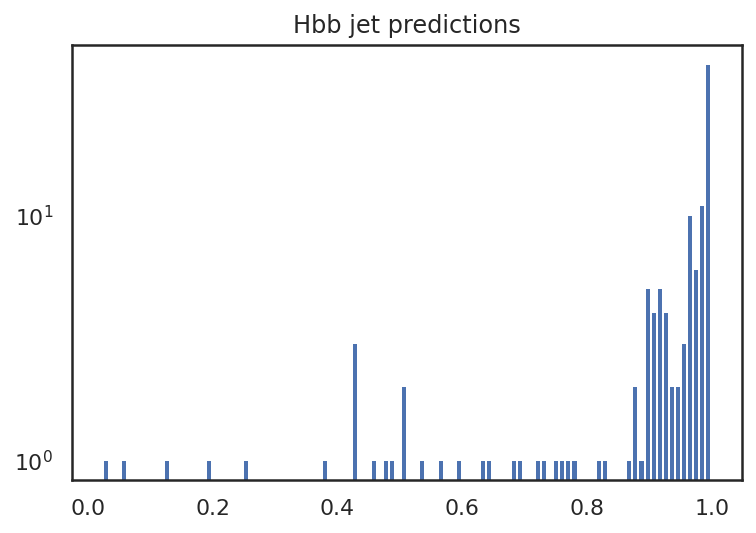

In [51]:
plt.hist(hbb_prob,bins=100,log=True)
plt.title("Hbb jet predictions")
plt.show()

In [80]:
selected_ix=np.argsort(hbb_prob)[::-1][:25]
for i in selected_ix:
    ix=hbb_idx[i]
    plot_interactive(relevance,ix,batch)

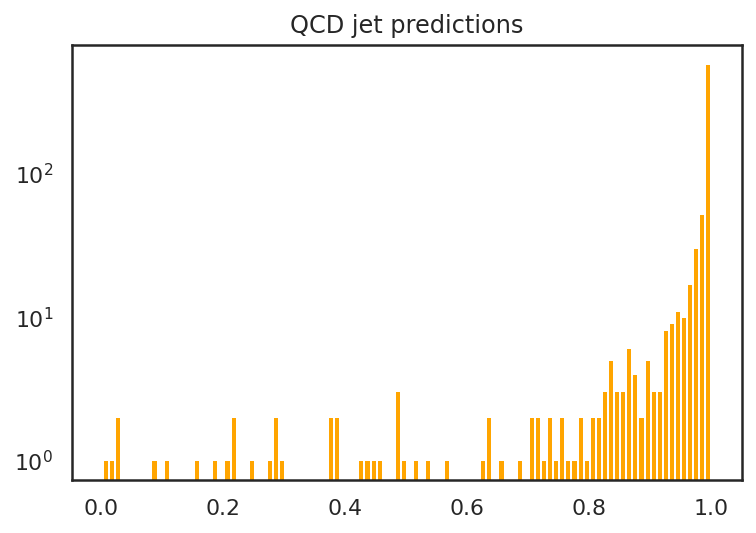

In [50]:
plt.hist(qcd_prob,bins=100,color="orange",log=True)
plt.title("QCD jet predictions")
plt.show()

In [81]:
selected_ix=np.argsort(qcd_prob)[::-1][:25]
for i in selected_ix:
    ix=qcd_idx[i]
    plot_interactive(relevance,ix,batch)

# most misclassified jets

In [82]:
selected_ix=np.argsort(hbb_prob)[:25]
for i in selected_ix:
    ix=hbb_idx[i]
    plot_interactive(relevance,ix,batch)

In [83]:
selected_ix=np.argsort(qcd_prob)[:25]
for i in selected_ix:
    ix=qcd_idx[i]
    plot_interactive(relevance,ix,batch)

# most confused jets (model cannot decide)

In [93]:
selected_ix=np.argsort(np.abs(np.array(hbb_prob)-0.5))[:10]

for i in selected_ix:
    ix=hbb_idx[i]
    plot_interactive(relevance,ix,batch)

In [94]:
selected_ix=np.argsort(np.abs(np.array(qcd_prob)-0.5))[:10]

for i in selected_ix:
    ix=qcd_idx[i]
    plot_interactive(relevance,ix,batch)